<h1><center>Analysis of Life Expectancy Data</center></h1>
<h3><center>Evan Nadelbach and Joseph Zietowski</center></h3>

### Importance of Global Health
The world's ongoing fight against Covid-19 makes it very clear that global health is of the utmost importance for the future of humanity, and as the world continues to become more and more physically connected, the importance of global health will continue to skyrocket. It is a misconception that global health doesn't affect everyone, especially those already living in "healthy" countries with access to good education and medicine. Global health is often described as a security issue, but it is also a political issue and even an economic issue. Ultimately, due to how fast diseases and ideas can spread, global health quickly turns into everyone’s issue. Improving global health and the well-being of all people is no easy task due to the extensive variation among populations, but, just like in any other complicated question, narrowing down the fundamental problem can help bring to light the real factors in play. In order make the problem as specific as possible, it is necessary to break it into smaller, easier problems that pertain to specific populations. To do this, we must first understand how to measure global health, and although there are countless factors, life expectancy is a great place to start due to its objectiveness and universality.

### What is life expectancy?
Life expectancy statistics may seem self-explanatory, but there are actually many different ways of measuring life expectancy, and some of them are biased more than others. Life expectancy at birth (LEB) is the measure we decided to use for this project. The world health organization defines <a href="https://www.who.int/data/gho/indicator-metadata-registry/imr-details/65">LEB</a> as "the average number of years that a newborn could expect to live, if he or she were to pass through life exposed to the sex- and age-specific death rates prevailing at the time of his or her birth, for a specific year, in a given country, territory, or geographic area." We could have chosen another measure such as life expectancy at age 60 or healthy life expectancy at birth/age 60, but since we are more concerned with general trends and comparing life expectancies between populations than with the actual number of years, we chose a very basic statistic. It is also important to understand that since we want to look at data from recent years, the true/<i>Cohort</i> life expectancy can't be computed for people born in those years since not all of them have died. Consequently, the life expectancy data we are using is actually called <i>Period</i> LEB, which uses true/<i>Cohort</i> life expectancies from the past to predict the average life expectancy for a person born in a recent year.

### Purpose
The purpose of this tutorial is to analyze many factors that contribute either positively/negatively to life expectancy in populations around the world so that we can get a better understanding of which factors should be focused on the most in order to increase the well-being of people around the world. Data science is a perfect tool for this job because it allows us to break up the complicated data into understandable advice that can be put into action.

<h2>Data Collection</h2>

All the data we are using comes from the <a href="https://www.who.int/">World Health Organization</a>, a United Nations agency that specializes in international public health. We decided to choose a wide variety of factors that may contribute to life expectancy and global health. After importing life expectancy and 10 other features, our dataset will have 183 countries from 2000-2016 (3111 rows), and 11 features for each row (including life expectancy). One problem is that not all of the features contain all 183 countries and all 17 years. To account for this, we will use linear regression to predict the values for each missing year in each feature dataset. There usually isn't much missing data like this, so we don't suspect this will introduce substantial bias. On the other hand, most of the missing data is due to the feature datasets not having all the 183 countries. We will come back to this problem later.

In [306]:
!pip install plotly

In [307]:
import pandas as pd
import re
from sklearn import linear_model
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import plotly.express as px
from sklearn import preprocessing

pd.set_option('display.max_rows', None)

### Add the life expectancy <a href="https://apps.who.int/gho/data/view.main.SDG2016LEXv?lang=en">data</a> (<i>Period</i> Life expectancy at birth)
Our first step is to import our life expectancy data and get rid of the measures we aren't going to use

In [308]:
# read in the life expectancy data
df = pd.read_csv("data/life_expectancy.csv")

# remove the unwanted columns
df = df[["Country", "Year", "Life expectancy at birth (years) (Both sexes)"]]

# rename the columns
df = df.rename(columns={"Life expectancy at birth (years) (Both sexes)": "life_expectancy", \
                        "Country" : "country", "Year" : "year"})

# remove the rows that are not needed (year > 2016)
df.drop(df[df.year >= 2017].index, inplace=True)

df.head()

,country,year,life_expectancy
0,Afghanistan,2016,62.7
1,Afghanistan,2015,63.2
2,Afghanistan,2014,63.0
3,Afghanistan,2013,62.7
4,Afghanistan,2012,62.2


### Add the BMI <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/mean-bmi-(kg-m-)-(age-standardized-estimate)">data</a> (Age-standardized mean BMI (kg/m^2) 18+ years old)
For the BMI data, there is a small amount of missing data, so we filled it with the average BMI for that year. Since there was such a small amount of missing data, and BMIs seem fairly consistent between countries, we dont think this will introduce any noticible bias.

In [309]:
# read in the data
bmi = pd.read_csv("data/bmi.csv")

# drop the unwanted columns
bmi.drop('Indicator',axis=1,inplace=True)
bmi.drop('Dim2',axis=1,inplace=True)

# drop the unwanted rows
bmi.drop(bmi[bmi.Period < 2000].index, inplace=True)
bmi.drop(bmi[bmi.Dim1 == "Male"].index, inplace=True)
bmi.drop(bmi[bmi.Dim1 == "Female"].index, inplace=True)

# tidy the data in the bmi column
bmi["First Tooltip"].replace(["No data"], np.nan, inplace=True)
bmi["First Tooltip"].replace(["\[.*\]"], "", inplace=True, regex=True)
bmi["First Tooltip"] = bmi["First Tooltip"].astype(float)

# get the mean bmi
bmi_mean = round(bmi.groupby('Period', as_index=False)['First Tooltip'].mean(), 1)

# merge the data into our life expectancy dataframe
df = df.merge(bmi, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)
df.drop('Dim1', axis=1, inplace=True)

# rename the BMI column
df = df.rename(columns={"First Tooltip": "bmi"})

# mean imputation
for index, row in df.iterrows():
    if (str(row['bmi']) == "nan"):
        df.at[index, 'bmi'] = bmi_mean.loc[bmi_mean['Period'] == row['year']]['First Tooltip']
        
df['bmi'] = df['bmi'].astype(float)

### Add the drinking-water <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/population-using-safely-managed-drinking-water-services-(-)">data</a> (% of population using at least basic drinking-water services)
For the drinking water data, we will use linear regression to fill in the data for the very few instances of missing years.

In [310]:
import matplotlib.pyplot as plt

# read in the data
drinking_water = pd.read_csv("data/drinking_water.csv")

# drop unwanted rows
indicator = "Population using at least basic drinking-water services (%)"
drinking_water.drop(drinking_water[drinking_water.Indicator != indicator].index, inplace=True)

# drop unwanted columns
drinking_water.drop("Indicator", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in drinking_water['Location'].unique():
    
    # Get only the data for the current country.
    currdata = drinking_water.loc[drinking_water['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            drinking_water = drinking_water.append({'Location': i, 'Period': k, \
                                                    'First Tooltip': round(reg.predict([[k]])[0], 2)}, ignore_index=True)


# merge the data into our life expectancy dataframe
df = df.merge(drinking_water, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the drinking-water column
df = df.rename(columns={"First Tooltip": "drinking_water"})

### Add the government expenditure <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/general-government-expenditure-on-health-as-a-percentage-of-total-government-expenditure">data</a> (% of government expenditure on general health)
For the government expenditure data, we will once again use linear regression to fill in the data for the missing years.

In [311]:
# read in the data
government_expenditure = pd.read_csv("data/government_expenditure.csv")

# drop unwanted columns
government_expenditure.drop("Indicator", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in government_expenditure['Location'].unique():
    
    # Get only the data for the current country.
    currdata = government_expenditure.loc[government_expenditure['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            government_expenditure = government_expenditure.append({'Location': i, \
                                                                    'Period': k, \
                                                                    'First Tooltip': round(reg.predict([[k]])[0], 2)}, \
                                                                   ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(government_expenditure, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the government expenditure column
df = df.rename(columns={"First Tooltip": "government_expenditure"})

### Add the hospital beds <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/hospital-beds-(per-10-000-population)">data</a> (Number of hospital beds available per 10,000 population)
Import the hospital beds data and use linear regression to fill in data for the missing years.

In [312]:
# read in the data
hospital_beds = pd.read_csv("data/hospital_beds.csv")

hospital_beds

# drop unwanted columns
hospital_beds.drop("Indicator", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in hospital_beds['Location'].unique():
    
    # Get only the data for the current country.
    currdata = hospital_beds.loc[hospital_beds['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            hospital_beds = hospital_beds.append({'Location': i, 'Period': k, \
                                                  'First Tooltip': round(reg.predict([[k]])[0], 2)}, ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(hospital_beds, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the hospital_beds column
df = df.rename(columns={"First Tooltip": "hospital_beds"})

### Add the homicide <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/estimates-of-rates-of-homicides-per-100-000-population">data</a> (Estimates of rates of homicides per 100,000 population)
Import the homicide data and use linear regression to fill in data for the missing years.

In [313]:
# read in the data
homicides = pd.read_csv("data/homicides.csv")

# drop unwanted rows
homicides.drop(homicides[homicides.Dim1 != "Both sexes"].index, inplace=True)

# drop unwanted columns
homicides.drop("Indicator", axis=1, inplace=True)
homicides.drop("Dim1", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in homicides['Location'].unique():
    
    # Get only the data for the current country.
    currdata = homicides.loc[homicides['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            homicides = homicides.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 2)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(homicides, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the homicides column
df = df.rename(columns={"First Tooltip": "homicides"})

### Add the malaria <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/malaria-incidence-(per-1-000-population-at-risk)">data</a> (Malaria incidence per 1,000 population at risk)
For the malaria data, many countries in the world have very little or no cases of malaria due to the climate. These countries were not included in the dataset, so we can add them manually and assume that the incidence is 0. We stil want to do linear regression on the countries with missing years though. It turns out that malaria varies greatly between countries due to the climate and how developed that country is. It will be interesting to see how this plays into our analysis.

In [314]:
# read in the data
malaria = pd.read_csv("data/malaria.csv")

# drop unwanted columns
malaria.drop("Indicator", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in malaria['Location'].unique():
    
    # Get only the data for the current country.
    currdata = malaria.loc[malaria['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            malaria = malaria.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 2)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(malaria, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the malaria column
df = df.rename(columns={"First Tooltip": "malaria"})

df["malaria"].fillna(0, inplace=True)

### Add the pollution <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/gho-phe-primary-reliance-on-clean-fuels-and-technologies-proportion">data</a> (% of population with primary reliance on clean fuels and technologies)
Import the pollution data and use linear regression to fill in data for the missing years.

In [315]:
# read in the data
pollution = pd.read_csv("data/pollution.csv")

# drop unwanted columns
pollution.drop("Indicator", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in pollution['Location'].unique():
    
    # Get only the data for the current country.
    currdata = pollution.loc[pollution['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            pollution = pollution.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 2)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(pollution, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the government expenditure column
df = df.rename(columns={"First Tooltip": "pollution"})

### Add the suicide <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/age-standardized-suicide-rates-(per-100-000-population)">data</a> (Age-standardized suicide rates per 100,000 population)
Import the suicide data and use linear regression to fill in data for the missing years.

In [316]:
# read in the data
suicides = pd.read_csv("data/suicide.csv")

# drop unwanted rows
suicides.drop(suicides[suicides.Dim1 != "Both sexes"].index, inplace=True)

# drop unwanted columns
suicides.drop("Indicator", axis=1, inplace=True)
suicides.drop("Dim1", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in suicides['Location'].unique():
    
    # Get only the data for the current country.
    currdata = suicides.loc[suicides['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            suicides = suicides.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 1)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(suicides, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the suicides column
df = df.rename(columns={"First Tooltip": "suicides"})

### Add the tuberculosis <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/deaths-due-to-tuberculosis-among-hiv-negative-people-(per-100-000-population)">data</a> (Deaths due to tuberculosis among HIV-negative people per 100,000 population)
Import the tuberculosis data and use linear regression to fill in data for the missing years.

In [317]:
# read in the data
tuberculosis = pd.read_csv("data/tuberculosis.csv")

# drop unwanted column
tuberculosis.drop("Indicator", axis=1, inplace=True)

# tidy the data in the tuberculosis column
tuberculosis["First Tooltip"].replace(["\[.*\]"], "", inplace=True, regex=True)

tuberculosis["Location"].replace(["Sudan \(until 2011\)"], "Sudan", inplace=True, regex=True)

# This loop will iterate for each country in the dataset
for i in tuberculosis['Location'].unique():
    
    # Get only the data for the current country.
    currdata = tuberculosis.loc[tuberculosis['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            tuberculosis = tuberculosis.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 1)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(tuberculosis, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the tuberculosis column
df = df.rename(columns={"First Tooltip": "tuberculosis"})

# change the column from a string to a float64
df['tuberculosis'] = df['tuberculosis'].astype(np.float64)

### Add the under-five deaths <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/under-five-mortality-rate-(probability-of-dying-by-age-5-per-1000-live-births)">data</a> (Probability of a child dying before reaching the age of five)
Import the under-five deaths data and use linear regression to fill in data for the missing years.

In [318]:
# read in the data
under_five_deaths = pd.read_csv("data/under_five_deaths.csv")

# drop unwanted rows
under_five_deaths.drop(under_five_deaths[under_five_deaths.Dim1 != "Both sexes"].index, inplace=True)
indicator = "Infant mortality rate (probability of dying between birth and age 1 per 1000 live births)"
under_five_deaths.drop(under_five_deaths[under_five_deaths.Indicator != indicator].index, inplace=True)

# drop unwanted column
under_five_deaths.drop("Indicator", axis=1, inplace=True)
under_five_deaths.drop("Dim1", axis=1, inplace=True)

# tidy the data in the under_five_deaths column
under_five_deaths["First Tooltip"].replace(["\[.*\]"], "", inplace=True, regex=True)
under_five_deaths["Location"].replace(["Sudan \(until 2011\)"], "Sudan", inplace=True, regex=True)

# This loop will iterate for each country in the dataset
for i in under_five_deaths['Location'].unique():
    
    # Get only the data for the current country.
    currdata = under_five_deaths.loc[under_five_deaths['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            under_five_deaths = under_five_deaths.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 1)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(under_five_deaths, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the under five deaths column
df = df.rename(columns={"First Tooltip": "under_five_deaths"})

# change the column from a string to a float64
df['under_five_deaths'] = df['under_five_deaths'].astype(np.float64)

In [319]:
# print the completed dataset
df.head()

,country,year,life_expectancy,bmi,drinking_water,government_expenditure,hospital_beds,homicides,malaria,pollution,suicides,tuberculosis,under_five_deaths
0,Afghanistan,2016,62.7,23.4,54.84,13.31,5.0,7.40,26.11,31.0,6.4,34.0,51.32
1,Afghanistan,2015,63.2,23.3,52.39,12.75,5.0,7.40,14.91,29.0,6.6,39.0,53.17
2,Afghanistan,2014,63.0,23.2,49.96,12.00,5.0,7.75,12.67,27.0,6.7,43.0,55.16
3,Afghanistan,2013,62.7,23.0,47.56,10.59,5.3,7.77,9.01,25.0,6.8,43.0,57.23
4,Afghanistan,2012,62.2,22.9,45.19,11.67,5.3,7.80,11.15,23.0,6.9,44.0,59.45


We have now imported all of the data we will need, but there are missing values. Lets look at the number of missing values in each colum and the total percentage of missing data:

In [320]:
# print the number of missing data points in each column
print(df.isna().sum())

# calculate the percentage of missing data in our dataset
missing_percentage = df.isna().sum().sum() / (len(df) * (len(df.columns) - 1))
print("\nPercent of missing data: " + str(round(missing_percentage * 100, 3)))

country                     0
year                        0
life_expectancy             0
bmi                         0
drinking_water             34
government_expenditure     68
hospital_beds             119
homicides                  34
malaria                     0
pollution                 102
suicides                   34
tuberculosis               51
under_five_deaths          34
dtype: int64

Percent of missing data: 1.275


It seems as though 8 of our 10 additional features have missing data, but we can see that it doesn't add up to much missing data compared to the size of our dataset. Since we already filled in the data for the missing years when adding the features to the dataframe, we know that all of the missing data must be because the feature data doesn't include one or more of the 183 countries. We need to fill in this data so that we can later train a ML model with it, but unlike the very small amount missing data we already filled in, filling in this missing data has the potential to introduce a bias. Even though 1.275 is considered to be a low percentage, it is better to be safe, so we should do something to check the bias we introduce. There is nothing we can do to avoid this bias if we want data for all the countries, but there are some things we can do to reduce it as much as possible.

We decided to use the K-nearest neighbors imputer from sklearn to fill in this data. We found that using 10 neighbors and uniform weights for each point works the best at making good predictions.

In [321]:
# save the df before imputation (we can use this later for analyzing the accuracy of the imputation)
df_raw = df

# set up the KNN imputer
imputer = KNNImputer(n_neighbors=10, weights="uniform")

# pass in all the features
dftemp = imputer.fit_transform(df.values[:, 1:])

# turn the predictions into a pandas dataframe and add back the country column
dftemp = pd.DataFrame(dftemp)
dftemp.insert(0, "country", df["country"], True)

# rearrange the columns like they were originally
dftemp.columns = ['country', 'year', 'life_expectancy', 'bmi', 'drinking_water', 'government_expenditure', 'hospital_beds', \
                 'homicides', 'malaria', 'pollution', 'suicides', 'tuberculosis', 'under_five_deaths']

# change the type of the year column to an int
dftemp['year'] = dftemp['year'].astype(int)

# set df to the new imputed dataframe
df = dftemp

## Data Visualization and Analysis
It can be hard to know how much of a bias we have introduced into our dataset by imputing some of the data, but by graphing statistics about the features before and after the imputation, we should be able to get a better understanding of the extent of the bias introduced. The function below takes in one of the 10 features and graphs the mean and standard deviation over the 17 year period for the imputed data and the original data.

In [322]:
# Graphs the mean and stdev of the feature provided for both the original and imputed data. This function also takes
# in parameters for the names of the graph title and axis names
def graph_attributes(attribute, ylabel, title_mean, title_stdev):

    # Labels the x and y axes and sets the size of the plot
    plt.figure(figsize=(15, 6))

    # Set the first subplot
    plt.subplot(1, 2, 1)
    
    # Compute mean for each year and plot it (original data)
    mean = df_raw.groupby('year', as_index=False)[attribute].mean()
    plt.title(title_mean)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.plot(mean['year'], mean[attribute])
    
    # Compute mean for each year and plot it (imputed data)
    mean = df.groupby('year', as_index=False)[attribute].mean()
    plt.title(title_mean)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.plot(mean['year'], mean[attribute])
    
    # Create the legend
    plt.legend(['Before Imputation', 'After Imputation'], loc='upper left')

    # Set the second subplot
    plt.subplot(1, 2, 2)
    
    # Compute standard deviation for each year and plot it (original data)
    stdev = df_raw.groupby('year', as_index=False)[attribute].std()
    plt.title(title_stdev)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.plot(stdev['year'], stdev[attribute])
    
    # Compute standard deviation for each year and plot it (imputed data)
    stdev = df.groupby('year', as_index=False)[attribute].std()
    plt.title(title_stdev)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.plot(stdev['year'], stdev[attribute])
    
    # Create the legend
    plt.legend(['Before Imputation', 'After Imputation'], loc='upper left')

    plt.show()

Now lets call the function on life expectancy and each of the 10 features to compare the original data to the imputed data

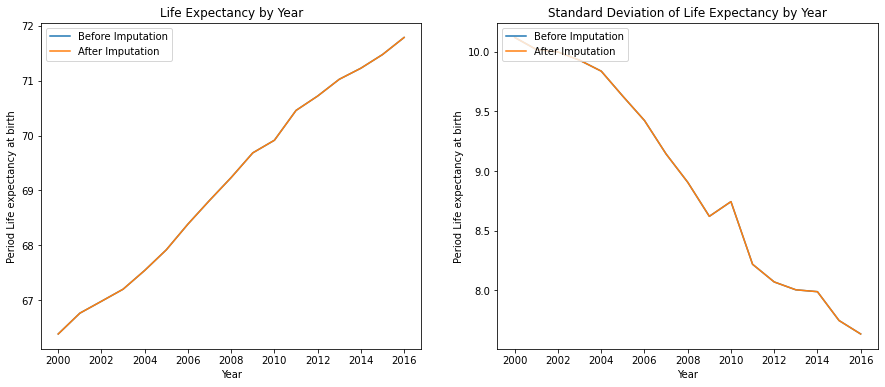

In [323]:
graph_attributes('life_expectancy', 'Period Life expectancy at birth', 'Life Expectancy by Year', \
                 'Standard Deviation of Life Expectancy by Year')

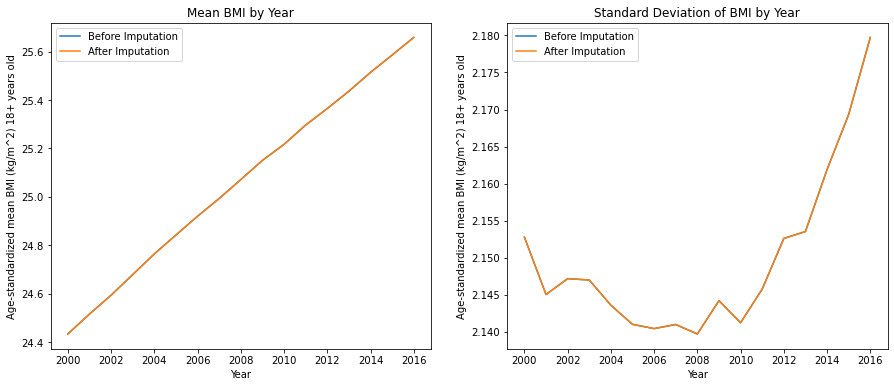

In [324]:
graph_attributes('bmi', 'Age-standardized mean BMI (kg/m^2) 18+ years old', 'Mean BMI by Year', \
                 'Standard Deviation of BMI by Year')

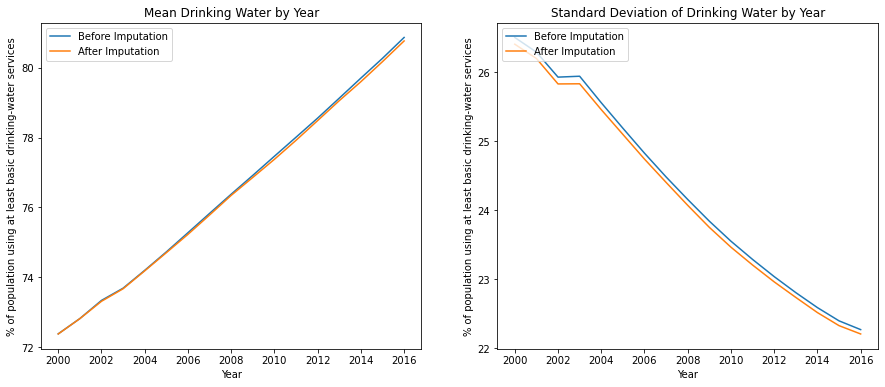

In [325]:
graph_attributes('drinking_water', '% of population using at least basic drinking-water services', \
                 'Mean Drinking Water by Year', 'Standard Deviation of Drinking Water by Year')

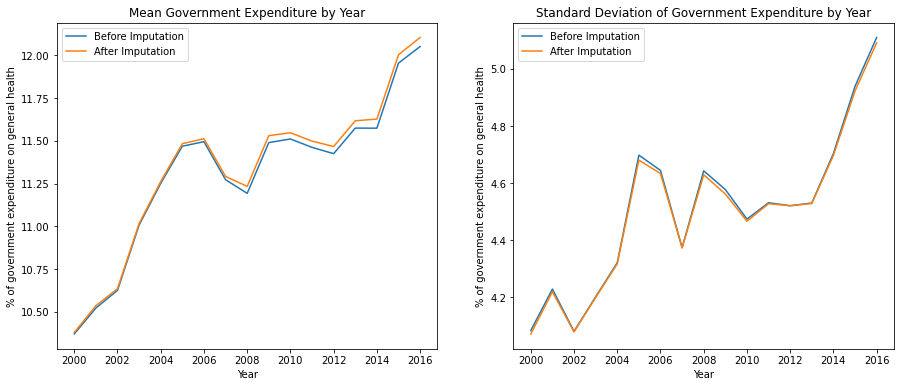

In [326]:
graph_attributes('government_expenditure', '% of government expenditure on general health', 'Mean Government Expenditure by Year', \
                 'Standard Deviation of Government Expenditure by Year')

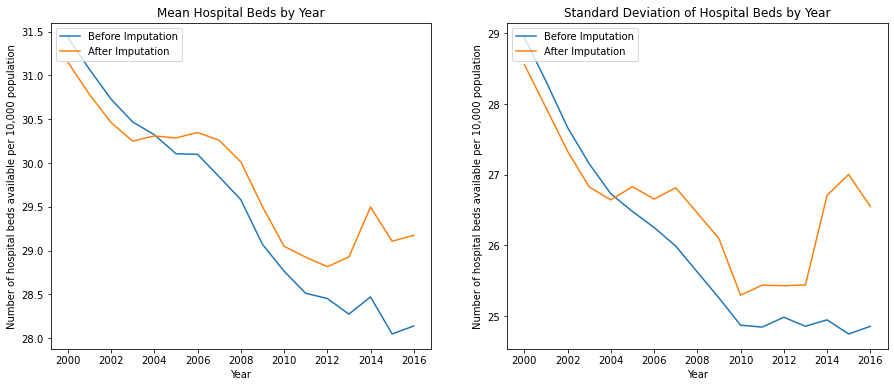

In [327]:
graph_attributes('hospital_beds', 'Number of hospital beds available per 10,000 population', 'Mean Hospital Beds by Year', \
                 'Standard Deviation of Hospital Beds by Year')

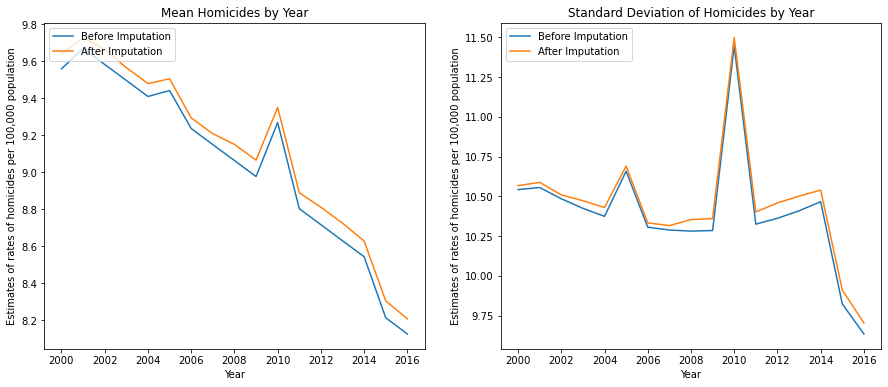

In [328]:
graph_attributes('homicides', 'Estimates of rates of homicides per 100,000 population', 'Mean Homicides by Year', \
                 'Standard Deviation of Homicides by Year')

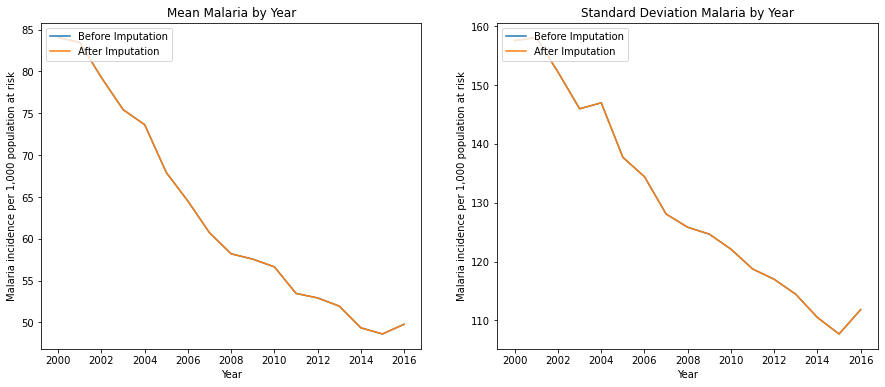

In [329]:
graph_attributes('malaria', 'Malaria incidence per 1,000 population at risk', 'Mean Malaria by Year', \
                 'Standard Deviation Malaria by Year')

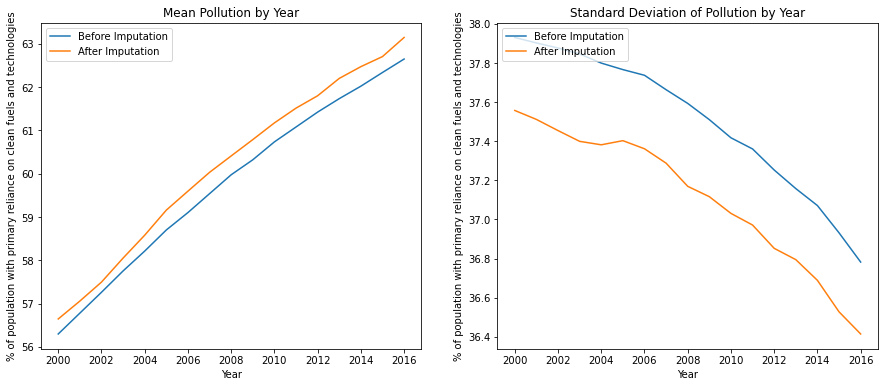

In [330]:
graph_attributes('pollution', '% of population with primary reliance on clean fuels and technologies', 'Mean Pollution by Year', \
                 'Standard Deviation of Pollution by Year')

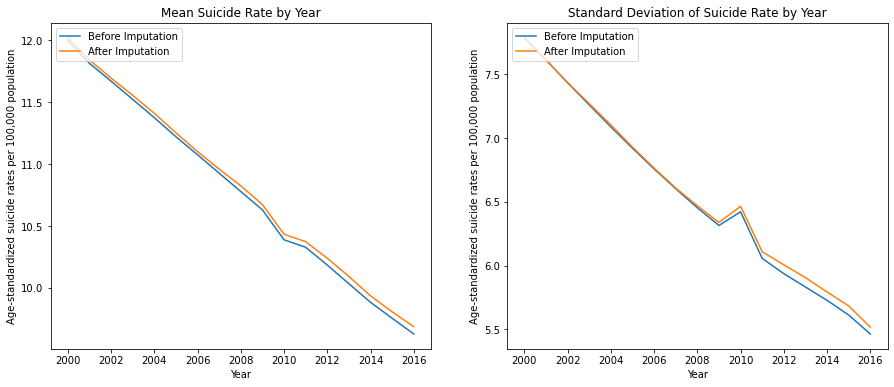

In [331]:
graph_attributes('suicides', 'Age-standardized suicide rates per 100,000 population', 'Mean Suicide Rate by Year', \
                 'Standard Deviation of Suicide Rate by Year')

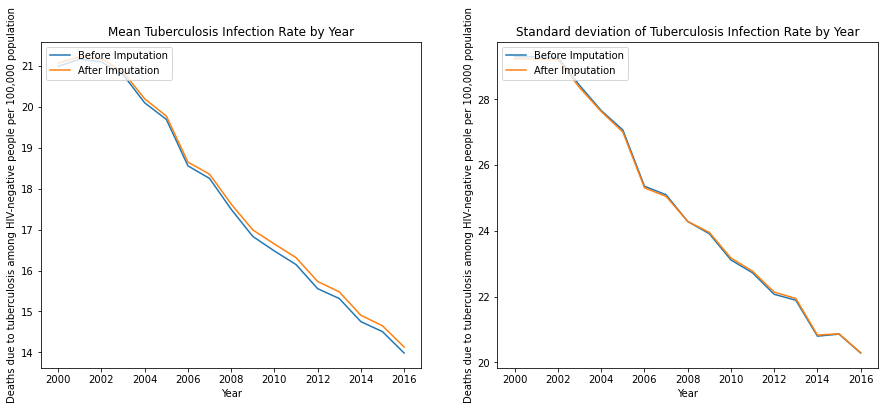

In [332]:
graph_attributes('tuberculosis', 'Deaths due to tuberculosis among HIV-negative people per 100,000 population', 'Mean Tuberculosis Infection Rate by Year', \
                 'Standard deviation of Tuberculosis Infection Rate by Year')

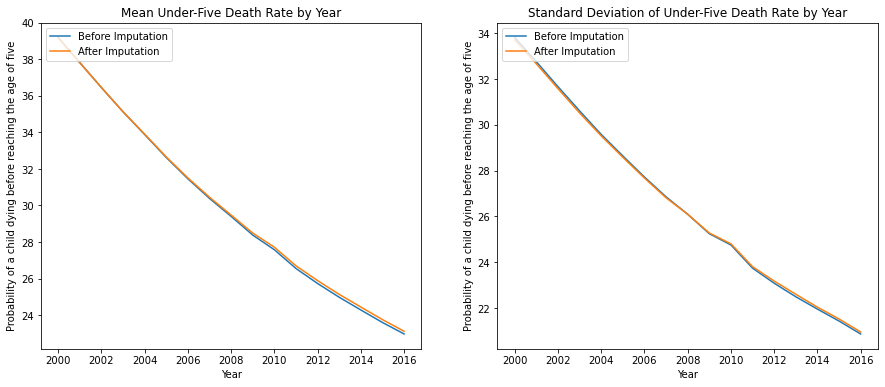

In [333]:
graph_attributes('under_five_deaths', 'Probability of a child dying before reaching the age of five', 'Mean Under-Five Death Rate by Year', \
                 'Standard Deviation of Under-Five Death Rate by Year')

The 22 graphs above show that our imputation didn't introduce a huge bias. The biggest mean and standard deviation changes occured for the data on hospital beds and pollution, which, unsuprisingly, were the two features with the most missing data. It is important that we keep an eye on these two features as we move on.

Now that we have an idea of how each feature is changing over time, lets look at the mean and standard deviation of life expectancy for each country over the 17 year time period. The bar graph below does this, ordering the countries by mean life expectancy.

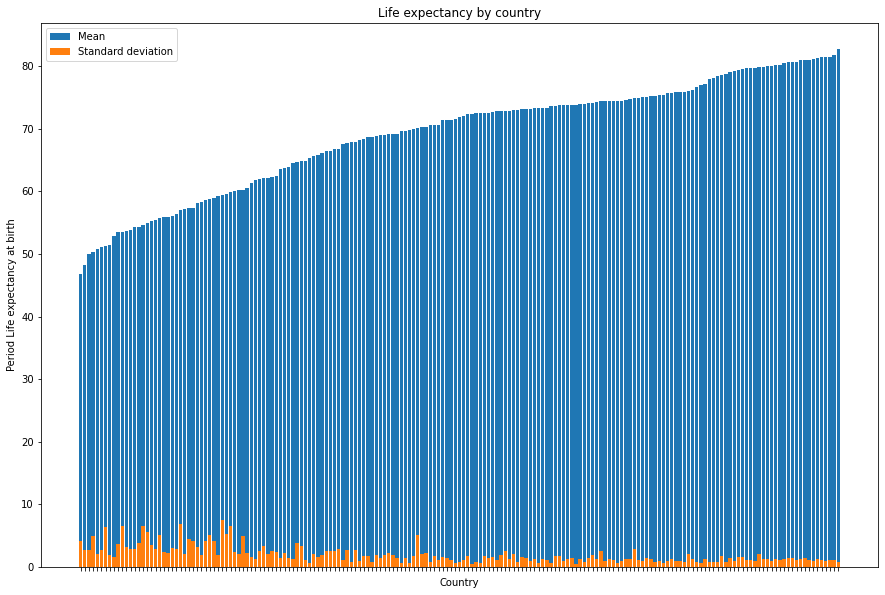

In [334]:
# Labels the x and y axes and sets the size of the plot
plt.figure(figsize=(15, 10))
plt.title('Life expectancy by country')
plt.xlabel('Country')
plt.ylabel('Period Life expectancy at birth')

# Creates a dataset that computes the mean and standard deviation of the life expectancy for each country
# and merges the two values into one table
life_exp_mean = df.groupby('country', as_index=False)['life_expectancy'].mean()
life_exp_std = df.groupby('country', as_index=False)['life_expectancy'].std()
life_exp = life_exp_mean.merge(life_exp_std, how="outer", left_on = ["country"],  right_on = ["country"])

# Renames columns to have more recognizable names
life_exp = life_exp.rename(columns={"life_expectancy_x": "mean", "life_expectancy_y": "stdev"})

# Sorts based on mean
life_exp.sort_values('mean', inplace=True)

# Plots the bar graph shown below
plt.bar(x=life_exp['country'], height=life_exp['mean'], tick_label='')
plt.bar(x=life_exp['country'], height=life_exp['stdev'], tick_label='')

# Creates the legend that shows mean and standard deviation by color
plt.legend(['Mean', 'Standard deviation'], loc='upper left')

plt.show()

This chart shows us that countries differ greatly with regards to mean life expectancy. The country with the highest mean life expectancy is almost twice as much as the country with the lowest mean life expectancy. Also, the stardard deviation of life expectancies within the 17 year period is much higher in countries with lower mean life expectancies. Hopefully this means that the life expectancy is just increasing faster in those countries.

## Analysis, Hypothesis Testing, ML

In [335]:
df = df[['country', 'year', 'bmi', 'drinking_water', 'government_expenditure', 'hospital_beds', 'homicides', 'malaria', \
        'pollution', 'suicides', 'tuberculosis', 'under_five_deaths', 'life_expectancy']]
df.head()

,country,year,bmi,drinking_water,government_expenditure,hospital_beds,homicides,malaria,pollution,suicides,tuberculosis,under_five_deaths,life_expectancy
0,Afghanistan,2016,23.4,54.84,13.31,5.0,7.40,26.11,31.0,6.4,34.0,51.32,62.7
1,Afghanistan,2015,23.3,52.39,12.75,5.0,7.40,14.91,29.0,6.6,39.0,53.17,63.2
2,Afghanistan,2014,23.2,49.96,12.00,5.0,7.75,12.67,27.0,6.7,43.0,55.16,63.0
3,Afghanistan,2013,23.0,47.56,10.59,5.3,7.77,9.01,25.0,6.8,43.0,57.23,62.7
4,Afghanistan,2012,22.9,45.19,11.67,5.3,7.80,11.15,23.0,6.9,44.0,59.45,62.2


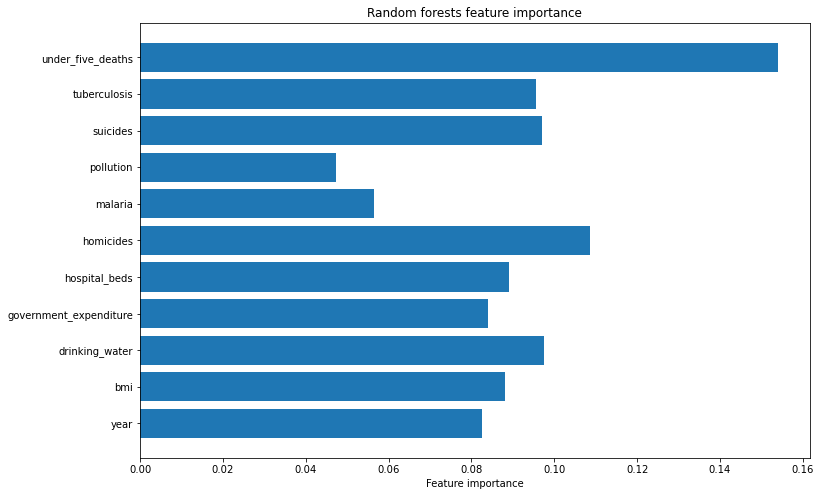

In [336]:
X = df.values[:, 1:-1]
y = df.values[:, -1].astype(int)

clf = RandomForestClassifier(n_estimators=100, criterion="gini")
clf = clf.fit(X, y)

plt.figure(figsize=(12, 8))
plt.title('Random forests feature importance')
plt.xlabel('Feature importance')

plt.barh(y=df.columns[1:-1], width=clf.feature_importances_)
plt.show()

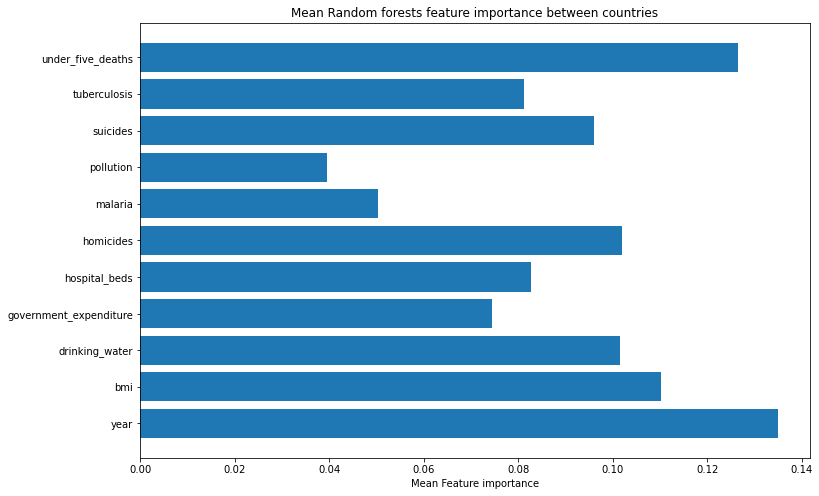

In [337]:
importances = np.empty((183, 11))
i = 0

for country in df['country'].unique():
    
    mask = df['country'] == country
    X = df[mask].values[:, 1:-1]
    y = df[mask].values[:, -1].astype(int)
    
    clf = RandomForestClassifier(n_estimators=100, criterion="gini")
    clf = clf.fit(X, y)
    importances[i] = clf.feature_importances_
    
    i += 1

mean_importances = []

for i in range(11):
    mean_importances.append(importances[:, i].mean())

plt.figure(figsize=(12, 8))
plt.title('Mean Random forests feature importance between countries')
plt.xlabel('Mean Feature importance')

plt.barh(y=df.columns[1:-1], width=mean_importances)
plt.show()

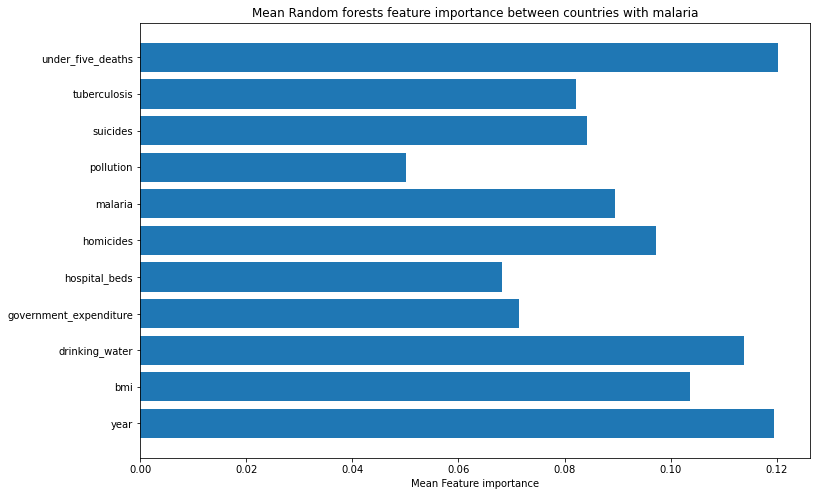

In [338]:
importances_df = pd.DataFrame(importances)
importances_df.insert(0, "country", df["country"].unique(), True)
importances_df.columns = ['country', 'year', 'bmi', 'drinking_water', 'government_expenditure', 'hospital_beds', \
                          'homicides', 'malaria', 'pollution', 'suicides', 'tuberculosis', 'under_five_deaths']

importances_dfcopy = importances_df.copy()

malaria_not0 = df.loc[df['malaria'] != 0]['country'].unique()
importances_df = importances_df[importances_df.country.isin(malaria_not0)]

importances_df.drop('country',axis=1,inplace=True)
importances_numpy = importances_df.to_numpy()

mean_importances2 = []

for i in range(11):
    mean_importances2.append(importances_numpy[:, i].mean())

plt.figure(figsize=(12, 8))
plt.title('Mean Random forests feature importance between countries with malaria')
plt.xlabel('Mean Feature importance')

plt.barh(y=df.columns[1:-1], width=mean_importances2)
plt.show()

### Importance by Country

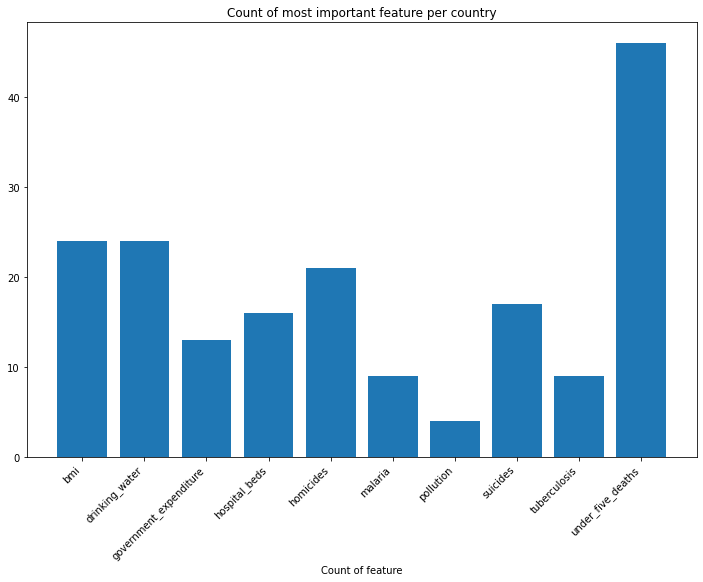

In [339]:
importances_df = importances_dfcopy.copy()
importances_df.drop('country',axis=1,inplace=True)
importances_df.drop('year',axis=1,inplace=True)

feature_counts = np.zeros(10)

for index, row in importances_df.iterrows():
    feature_counts[importances_df.columns.get_loc(row.idxmax())] += 1

plt.figure(figsize=(12, 8))
plt.title('Count of most important feature per country')
plt.xlabel('Count of feature')

plt.bar(x=df.columns[2:-1], height=feature_counts)
plt.xticks(rotation=45, ha="right")
plt.show()

In [340]:
df_by_country = pd.DataFrame()

for index, row in importances_df.iterrows():
    temp = [importances_dfcopy.loc[index, 'country']]
    temp.extend(row.sort_values(ascending=False).index)
    
    df_by_country = df_by_country.append([temp], ignore_index=True)

df_by_country.columns = ['country', '1st important feature', '2nd important feature', '3rd important feature', \
                         '4th important feature', '5th important feature', '6th important feature', '7th important feature', \
                         '8th important feature', '9th important feature', '10th important feature']

df_by_country.head()

,country,1st important feature,2nd important feature,3rd important feature,4th important feature,5th important feature,6th important feature,7th important feature,8th important feature,9th important feature,10th important feature
0,Afghanistan,under_five_deaths,homicides,suicides,drinking_water,pollution,bmi,malaria,tuberculosis,government_expenditure,hospital_beds
1,Albania,homicides,bmi,pollution,under_five_deaths,drinking_water,hospital_beds,government_expenditure,suicides,tuberculosis,malaria
2,Algeria,under_five_deaths,bmi,hospital_beds,government_expenditure,suicides,drinking_water,homicides,malaria,tuberculosis,pollution
3,Angola,government_expenditure,malaria,drinking_water,homicides,tuberculosis,suicides,under_five_deaths,bmi,pollution,hospital_beds
4,Antigua and Barbuda,bmi,homicides,hospital_beds,suicides,under_five_deaths,drinking_water,government_expenditure,tuberculosis,pollution,malaria


In [341]:
wc = r'countries.geo.json'

fig = px.choropleth(
    df_by_country, 
    geojson=wc, 
    color="1st important feature",
    locations="country", 
    locationmode = 'country names',
    featureidkey="feature.properties.name"
)

fig.show()

In [342]:
df.head()

,country,year,bmi,drinking_water,government_expenditure,hospital_beds,homicides,malaria,pollution,suicides,tuberculosis,under_five_deaths,life_expectancy
0,Afghanistan,2016,23.4,54.84,13.31,5.0,7.40,26.11,31.0,6.4,34.0,51.32,62.7
1,Afghanistan,2015,23.3,52.39,12.75,5.0,7.40,14.91,29.0,6.6,39.0,53.17,63.2
2,Afghanistan,2014,23.2,49.96,12.00,5.0,7.75,12.67,27.0,6.7,43.0,55.16,63.0
3,Afghanistan,2013,23.0,47.56,10.59,5.3,7.77,9.01,25.0,6.8,43.0,57.23,62.7
4,Afghanistan,2012,22.9,45.19,11.67,5.3,7.80,11.15,23.0,6.9,44.0,59.45,62.2


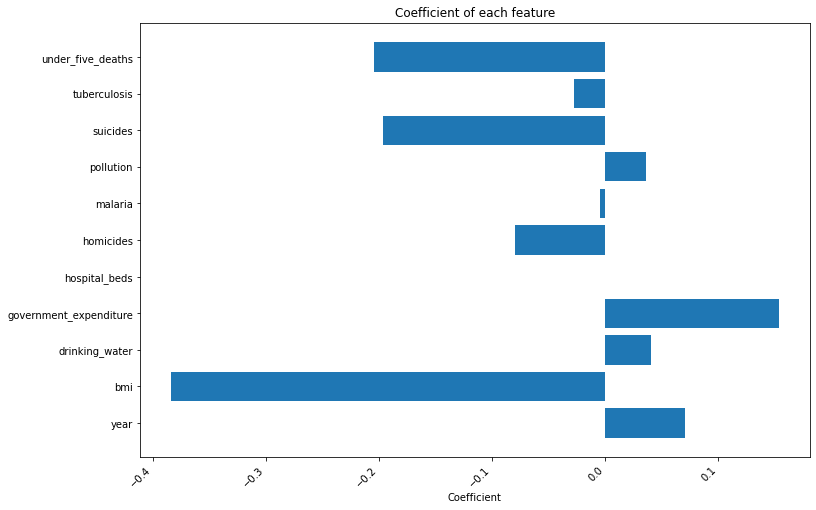

In [343]:
X = df.values[:, 1:-1]
y = df.values[:, -1].astype(int)

reg = LinearRegression().fit(X, y)

plt.figure(figsize=(12, 8))
plt.title('Coefficient of each feature')
plt.xlabel('Coefficient')

plt.barh(y=df.columns[1:-1], width=reg.coef_)
plt.xticks(rotation=45, ha="right")
plt.show()

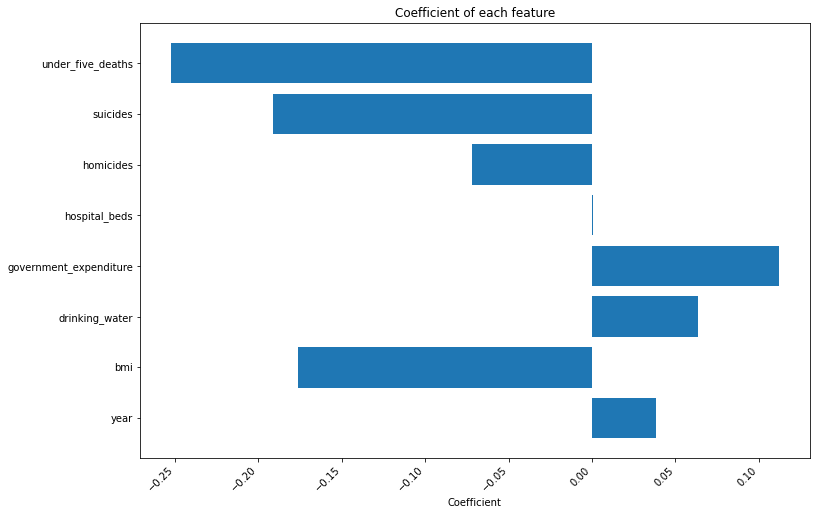

In [344]:
df2 = df.copy()
df2.drop('pollution',axis=1,inplace=True)
df2.drop('malaria',axis=1,inplace=True)
df2.drop('tuberculosis',axis=1,inplace=True)

X = df2.values[:, 1:-1]
y = df2.values[:, -1].astype(int)

reg = LinearRegression().fit(X, y)

plt.figure(figsize=(12, 8))
plt.title('Coefficient of each feature')
plt.xlabel('Coefficient')

plt.barh(y=df2.columns[1:-1], width=reg.coef_)
plt.xticks(rotation=45, ha="right")
plt.show()

In [345]:
from sklearn.neighbors import KNeighborsClassifier

df3 = df2.copy() 
for column in df3.columns[2:-1]:
    x_array = np.array(df3[column])
    X_scaled = preprocessing.scale(x_array)
    df3[column] = X_scaled

for country in df3["country"].unique():
    mask = df['country'] == country
    X = df3[mask].values[:, 1:-1]
    y = df3[mask].values[:, -1].astype(int)

    clf = KNeighborsClassifier(n_neighbors=10)
    clf.fit(X, y)

    i = 0
    first = clf.predict([df3.iloc[0][1:-1]])[0]

    print(country)
    for column in df3.columns[1:-1]:
        X = df3.iloc[0][1:-1]
        X[i] *= 1000
        print(str(abs(clf.predict([X])[0] - first)) + "   " + column)

        i += 1



Afghanistan
0   year
4   bmi
4   drinking_water
0   government_expenditure
0   hospital_beds
0   homicides
0   suicides
4   under_five_deaths
Albania
0   year
1   bmi
0   drinking_water
1   government_expenditure
0   hospital_beds
0   homicides
0   suicides
1   under_five_deaths
Algeria
0   year
1   bmi
1   drinking_water
0   government_expenditure
0   hospital_beds
0   homicides
0   suicides
1   under_five_deaths
Angola
0   year
14   bmi
14   drinking_water
1   government_expenditure
0   hospital_beds
0   homicides
0   suicides
14   under_five_deaths
Antigua and Barbuda
0   year
1   bmi
0   drinking_water
0   government_expenditure
1   hospital_beds
0   homicides
0   suicides
1   under_five_deaths
Argentina
0   year
2   bmi
2   drinking_water
2   government_expenditure
2   hospital_beds
0   homicides
0   suicides
2   under_five_deaths
Armenia
0   year
1   bmi
1   drinking_water
1   government_expenditure
0   hospital_beds
0   homicides
1   suicides
1   under_five_deaths
Australia
0   

0   government_expenditure
0   hospital_beds
0   homicides
0   suicides
2   under_five_deaths
Georgia
0   year
1   bmi
1   drinking_water
0   government_expenditure
0   hospital_beds
0   homicides
0   suicides
1   under_five_deaths
Germany
0   year
1   bmi
0   drinking_water
0   government_expenditure
0   hospital_beds
0   homicides
0   suicides
0   under_five_deaths
Ghana
0   year
5   bmi
5   drinking_water
4   government_expenditure
0   hospital_beds
0   homicides
4   suicides
5   under_five_deaths
Greece
0   year
1   bmi
0   drinking_water
0   government_expenditure
0   hospital_beds
0   homicides
0   suicides
0   under_five_deaths
Grenada
0   year
2   bmi
0   drinking_water
3   government_expenditure
0   hospital_beds
0   homicides
0   suicides
0   under_five_deaths
Guatemala
0   year
3   bmi
3   drinking_water
0   government_expenditure
0   hospital_beds
0   homicides
0   suicides
3   under_five_deaths
Guinea
0   year
6   bmi
0   drinking_water
0   government_expenditure
0   hospi

0   year
3   bmi
0   drinking_water
0   government_expenditure
3   hospital_beds
0   homicides
3   suicides
0   under_five_deaths
Republic of Moldova
0   year
2   bmi
2   drinking_water
0   government_expenditure
0   hospital_beds
0   homicides
0   suicides
2   under_five_deaths
North Macedonia
0   year
2   bmi
0   drinking_water
0   government_expenditure
0   hospital_beds
0   homicides
0   suicides
0   under_five_deaths
Romania
0   year
2   bmi
0   drinking_water
1   government_expenditure
0   hospital_beds
0   homicides
1   suicides
2   under_five_deaths
Russian Federation
0   year
6   bmi
6   drinking_water
6   government_expenditure
0   hospital_beds
0   homicides
0   suicides
6   under_five_deaths
Rwanda
0   year
20   bmi
20   drinking_water
15   government_expenditure
0   hospital_beds
0   homicides
0   suicides
20   under_five_deaths
Saint Lucia
0   year
3   bmi
3   drinking_water
0   government_expenditure
0   hospital_beds
0   homicides
0   suicides
0   under_five_deaths
Sain

In [346]:
df3

,country,year,bmi,drinking_water,government_expenditure,hospital_beds,homicides,suicides,under_five_deaths,life_expectancy
0,Afghanistan,2016,-0.763351,-0.886876,0.436305,-0.934949,-0.165860,-0.666086,0.779566,62.7
1,Afghanistan,2015,-0.809303,-0.987706,0.312408,-0.934949,-0.165860,-0.635928,0.847546,63.2
2,Afghanistan,2014,-0.855255,-1.087713,0.146474,-0.934949,-0.132324,-0.620850,0.920671,63.0
3,Afghanistan,2013,-0.947158,-1.186485,-0.165482,-0.923646,-0.130408,-0.605771,0.996735,62.7
4,Afghanistan,2012,-0.993110,-1.284023,0.073463,-0.923646,-0.127533,-0.590692,1.078311,62.2
5,Afghanistan,2011,-1.039062,-1.380737,-0.258405,-0.957555,-0.125617,-0.575613,1.162092,61.7
6,Afghanistan,2010,-1.085013,-1.476217,0.677463,-0.961323,-0.155320,-0.515298,1.249180,61.2
7,Afghanistan,2009,-1.130965,-1.570462,0.307983,-0.965091,-0.120826,-0.530377,1.338473,60.7
8,Afghanistan,2008,-1.176917,-1.663472,-0.975241,-0.965091,-0.118910,-0.515298,1.430705,60.2
9,Afghanistan,2007,-1.222869,-1.755660,-1.855798,-0.965091,-0.116993,-0.500220,1.526980,59.6
